In [1]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model = resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Create Dataset
TRAIN_ROOT = "/content/drive/MyDrive/dataset80-20/training"
TEST_ROOT = "/content/drive/MyDrive/dataset80-20/testing"

train_ds = ImageFolder(TRAIN_ROOT, transform=tfm)
test_ds = ImageFolder(TEST_ROOT, transform=tfm)

In [ ]:
# Length of Train and Test Datasets
LEN_TRAIN = len(train_ds)
LEN_TEST = len(test_ds)
print(LEN_TRAIN, LEN_TEST)

# Index Mapping
print(train_ds.class_to_idx)

12826 3206
{'cnv': 0, 'normal': 1}


In [ ]:
# Data Loader
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=30, shuffle = True)

In [ ]:
# Model
model = resnet18(pretrained=True)


model.fc = Linear(in_features=512, out_features=2)
model = model.to(device)
# model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [ ]:
# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

In [ ]:
for epoch in range(100):
    start = time()

    tr_acc = 0
    test_acc = 0

    # Train
    model.train()

    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()

            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()

            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()

            # training ends

            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))

        ep_tr_acc = tr_acc / LEN_TRAIN

    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()

            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))

        ep_test_acc = test_acc / LEN_TEST

    end = time()
    duration = (end - start) / 60

    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")

100%|██████████| 375/375 [35:30<00:00,  5.68s/batch]


Epoch: 0, Time: 61.52941396633784, Loss: 4.8754307499621063e-05
Train_acc: 0.9866357804704206, Test_acc: 0.9906405990016639


100%|██████████| 375/375 [01:45<00:00,  3.57batch/s]


Epoch: 1, Time: 2.4878663539886476, Loss: 0.01472835149616003
Train_acc: 0.9959016393442623, Test_acc: 0.9758735440931781


100%|██████████| 375/375 [01:47<00:00,  3.50batch/s]


Epoch: 2, Time: 2.527320631345113, Loss: 0.00021660725178662688
Train_acc: 0.9962580185317177, Test_acc: 0.9898086522462562


100%|██████████| 375/375 [01:43<00:00,  3.62batch/s]


Epoch: 3, Time: 2.470316195487976, Loss: 0.0007139143417589366
Train_acc: 0.9963471133285816, Test_acc: 0.9941763727121464


100%|██████████| 375/375 [01:44<00:00,  3.60batch/s]


Epoch: 4, Time: 2.4550928274790444, Loss: 0.001028000027872622
Train_acc: 0.998039914468995, Test_acc: 0.9916805324459235


In [ ]:
model_path = '/content/drive/MyDrive/models 70-30/model-resnet18-70-30.pth'

# Save the model
torch.save(model.state_dict(), model_path)

# Model Performance on Samples

In [ ]:
# Image Samples
sample_1 = '/content/drive/MyDrive/cnv sample/CNV-8833506-7.jpeg'
sample_2 = '/content/drive/MyDrive/cnv sample/CNV-8833506-84.jpeg'
sample_3 = '/content/drive/MyDrive/normal sample/NORMAL-2137983-15.jpeg'
sample_4 = '/content/drive/MyDrive/normal sample/NORMAL-2150315-2.jpeg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

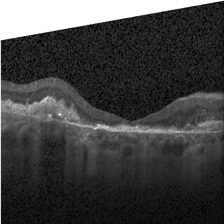

Model prediction 0, affected


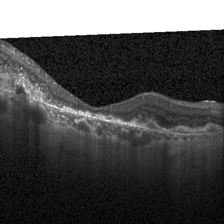

Model prediction 0, affected


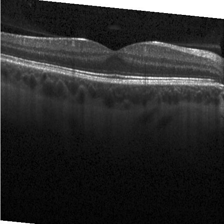

Model prediction 1, Not affected


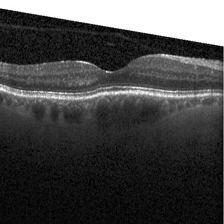

Model prediction 1, Not affected


In [ ]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, Not affected")
    else:
        print(f"Model prediction {pred}, affected")

    print("========================================================")

In [ ]:
import torch
from torchvision.models import resnet18
from torch.nn import Linear

# Define the path to the saved model
model_path = "/content/drive/MyDrive/models 60-40/model-resnet18-70-30.pth"

# Load the ResNet18 model architecture
model = resnet18(pretrained=True)

# Modify the model's final fully connected layer to match the number of classes in your dataset (2 in your case)
model.fc = Linear(in_features=512, out_features=2)

# Load the model's learned weights
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Set the model in evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
TEST1_ROOT = "/content/drive/MyDrive/testing"
test1_ds = ImageFolder(TEST1_ROOT, transform=tfm)
LEN_TEST1 = len(test1_ds)
print(LEN_TEST1)
test1_loader = DataLoader(test1_ds, batch_size=30, shuffle = True)

484


Confusion Matrix:
[[242   0]
 [  0 242]]

Classification Report:
              precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



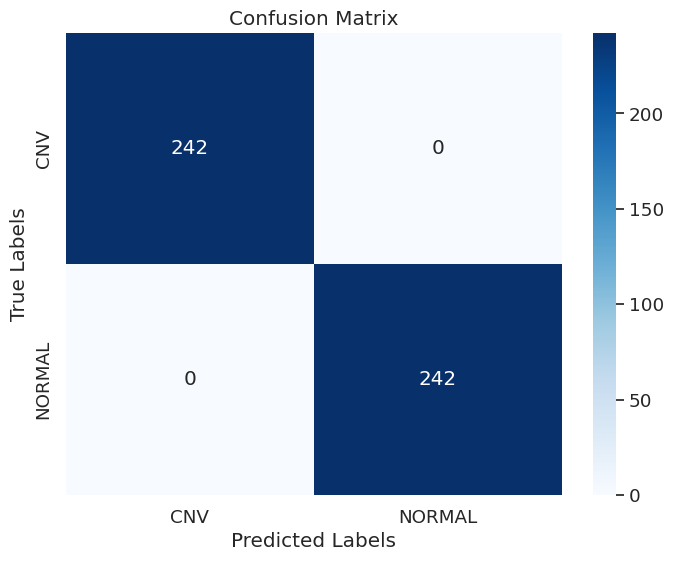

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Put the model in evaluation mode
model.eval()

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for xtest1, ytest1 in test1_loader:
        xtest1 = xtest1.to(device)
        test1_prob = model(xtest1)
        test1_pred = torch.max(test1_prob, 1).indices.cpu().numpy()
        true_labels.extend(ytest1.cpu().numpy())
        predicted_labels.extend(test1_pred)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate the classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['CNV', 'NORMAL'])

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the colorful confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["CNV", "NORMAL"], yticklabels=["CNV", "NORMAL"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from PIL import Image
import numpy as np

# Load the saved model
model_path = '/content/drive/MyDrive/models 80-20/model-resnet18-80-20.pth'
model = resnet18(pretrained=True)
model.fc = Linear(in_features=512, out_features=2)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

from sklearn.metrics import confusion_matrix

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Put the model in evaluation mode
model.eval()

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for xtest, ytest in test_loader:
        xtest = xtest.to(device)
        test_prob = model(xtest)
        test_pred = torch.max(test_prob, 1).indices.cpu().numpy()
        true_labels.extend(ytest.cpu().numpy())
        predicted_labels.extend(test_pred)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Get indices of True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
TP_indices = np.where((true_labels == 1) & (predicted_labels == 1))[0]
FP_indices = np.where((true_labels == 0) & (predicted_labels == 1))[0]
TN_indices = np.where((true_labels == 0) & (predicted_labels == 0))[0]
FN_indices = np.where((true_labels == 1) & (predicted_labels == 0))[0]

# Define a function to display and label images
def display_and_label_images(indices, label):
    for i in indices[:5]:  # Display only the first 5 images for each label
        image_path = test_ds.samples[i][0]
        img = Image.open(image_path)
        display(img.resize((224, 224)))
        print(f"True Label: {true_labels[i]}, Predicted Label: {predicted_labels[i]}, {label}")
        print("========================================================")

# Display True Positives (TP)
display_and_label_images(TP_indices, "True Positive (TP)")

# Display False Positives (FP)
display_and_label_images(FP_indices, "False Positive (FP)")

# Display True Negatives (TN)
display_and_label_images(TN_indices, "True Negative (TN)")

# Display False Negatives (FN)
display_and_label_images(FN_indices, "False Negative (FN)")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored

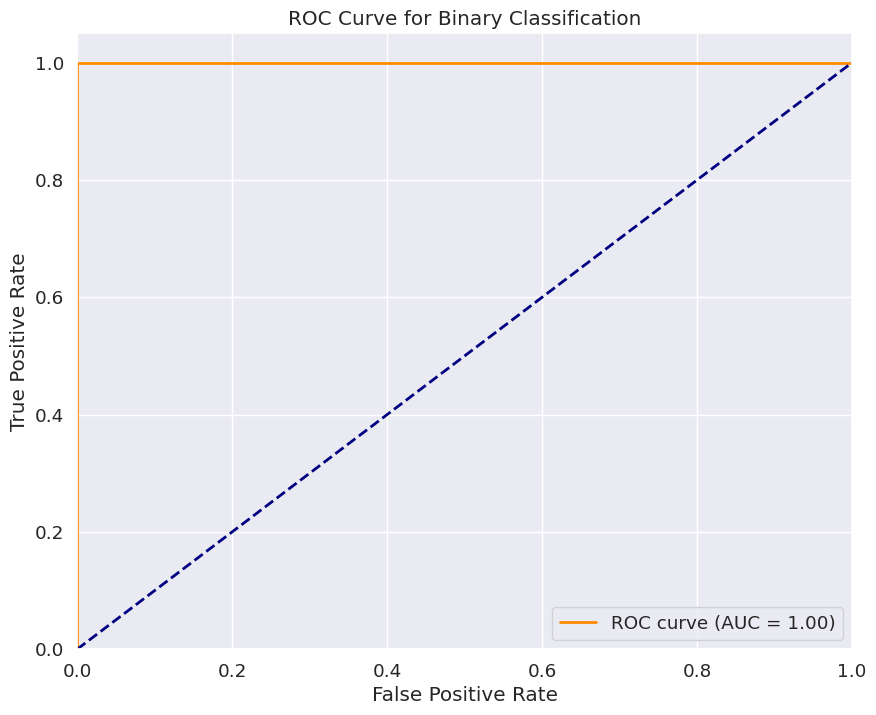

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Put the model in evaluation mode
model.eval()

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for xtest1, ytest1 in test1_loader:
        xtest1 = xtest1.to(device)
        test1_prob = model(xtest1)
        test1_prob = test1_prob.cpu().numpy()[:, 1]  # Probability of the positive class
        true_labels.extend(ytest1.cpu().numpy())
        predicted_probs.extend(test1_prob)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right")
plt.show()
